In [1]:
# Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import sklearn as sk
from keras.layers import Dropout
from sklearn import metrics
import datetime as dt
import custom_metrics
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras as keras
import seaborn as sns

In [11]:
def prepare_dataset(data, look_back=1, forecast_step=1):
    """
    Подготавливает датасет для LSTM модели. Метод разбивает полученные данные на последовательности с заданой величиной последовательности look_back
   
    Параметры:
    data - исходный DataFrame с колонками
    look_back - сколько предыдущих шагов учитывать (по стандарту - 1)
    forecast_step - на сколько шагов вперёд прогнозируем (n+1)
    
    Возвращает:
    X - массив с признаками [n-lookback .. n, погодные признаки n+1]
    y - целевая переменная (генерация в n+1)
    """
    # Масштабирование данных (нормализация в диапазон [0, 1])
    # scaler = MinMaxScaler()
    # data_scaled = scaler.fit_transform(data)

    data_np = data.to_numpy()
    
    X, y = [], []
    
    for i in range(look_back, len(data)-forecast_step):
        # Данные за n-1 (все параметры)
        prev_step = data_np[i-look_back:i].flatten()
        
        # Данные за n (все параметры)
        current_step = data_np[i].flatten()
        
        # Только погодные данные за n+1
        future_weather = data_np[i+forecast_step, 1:]
        
        # Объединяем все признаки
        features = np.concatenate([prev_step, current_step, future_weather])
        X.append(features)
        
        # Целевая переменная - генерация в n+1
        target = data_np[i+forecast_step, 0]
        y.append(target)
    
    return np.array(X), np.array(y)

def create_rolling_window_and_scale(data, look_back=4):
    """
    Создаёт временные последовательности и маштабирует данные. Использую для кросс-валлидации
    """
    X, y = prepare_dataset(data, look_back)
    # Масштабирование данных (нормализация в диапазон [0, 1])
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    X = scaler_X.fit_transform(X)
    y = scaler_y.fit_transform(y.reshape(-1, 1)) # форма изменяется до вида (колл-во срезов, 1)
    
    # Изменение формы данных для LSTM (добавляем временную размерность)
    # X.shape: (samples, features) -> (samples, 1, features)
    X = X.reshape((X.shape[0], 1, X.shape[1]))

    return X, y, scaler_X, scaler_y

# Генератор последовательностей для TimeSeriesSplit
def create_sequences(X, y, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(targets[i+timesteps])
    return np.array(X), np.array(y)

def data_split (data, train_size_):
    """
    Разделяет данные на тренировочную и тестовую выборку.\n Возвращает сначала тренировочную выборку, затем тестовую.
    """
    data_train, data_test = data[:train_size_], data[train_size_:]
    return data_train, data_test

def data_split_and_prepare(data, look_back=4, train_size_=0.8):
    """
    Метод разбивает получет данные data. В данных первый столбец - прогнозируемый признак.\n Метод разбивает полученные данные на последовательности с заданой величиной последовательности look_back.
    Затем данные маштабируются и формируются test и train массивы с заданной величиной тренировочного массива train_size_.\n Также метод возращает scaler для дальнейшего обратного преобразования.
    """
    X, y = prepare_dataset(data, look_back) # makes from data X and y arrays

    # Масштабирование данных (нормализация в диапазон [0, 1])
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    X = scaler_X.fit_transform(X)
    y = scaler_y.fit_transform(y.reshape(-1, 1)) # форма изменяется до вида (колл-во срезов, 1)
    
    # Изменение формы данных для LSTM (добавляем временную размерность)
    # X.shape: (samples, features) -> (samples, 1, features)
    X = X.reshape((X.shape[0], 1, X.shape[1]))
    
    # Разделение данных на обучающую и val выборки
    train_size = int(len(X) * train_size_)
    X_train, X_vals = data_split(X, train_size) # данные должны быть последовательными, поэтому делю не смешивая
    y_train, y_vals = data_split(y, train_size) 

    return X_train, X_vals, y_train, y_vals, scaler_X, scaler_y

# NN creating
def create_LSTM_model(data_shape, LSTM_units=120, actication='relu', loss='mae', dropout=None, optimizer='adam'):
    """
    В методе собраны все шаги по построение LSTM. Возвращает скомпилированную модель
    """
    model = Sequential()
    model.add(LSTM(LSTM_units, activation='relu', input_shape=(data_shape[1], data_shape[2])))  # LSTM слой
    if dropout != None:
        model.add(Dropout(dropout)) # Вероятность отключения нейрона = значинию Dropout
    model.add(Dense(1))  # Выходной слой для прогнозирования одного значения
    model.compile(optimizer=optimizer, loss=loss, metrics=['mse'])  # Оптимизатор Adam и функция потерь MAE
    return model

## Подготовка данных Черновская СЭС

In [709]:
# Считывание погодных данных
weather_data = pd.read_csv('weather data chernov.csv')

weather_data = weather_data.rename(columns = {'time': 'Date'})
weather_data.Date = pd.to_datetime(weather_data.Date, format='ISO8601', errors='coerce')

In [711]:
generation_data = pd.read_excel("Данные ОИК ЧСЭС 01.05.2024 - 14.12.2024.xlsx")
new_column = generation_data.iloc[:,1] + generation_data.iloc[:,2]
generation_data = generation_data.drop(generation_data.columns[[1,2]], axis=1)
generation_data = generation_data.drop(0)
generation_data.insert(1, 'ПГБР Pген ГОУ Черновская', new_column)
columns_name = ['Date', 'Plan_X-1_Pgen', 'Fact_Pgen', 'Forecast_15_min', 'Forecast_30_min', 'Forecast_45_min', 'Forecast_60_min',
               'Forecast_2_hour', 'Forecast_3_hour', 'Forecast_4_hour', 'Insolation', "Temperature", 'Wind_speed']
generation_data.columns = columns_name
generation_data = generation_data.reset_index(drop=True)
generation_data.Date = pd.to_datetime(generation_data.Date)

Pgen = generation_data[['Date', 'Fact_Pgen']] # оставляю только дату для merge и генерацию

In [712]:
# using open-meteo weather data
data_merge = pd.merge(Pgen, weather_data, on='Date', how='left').drop_duplicates('Date') # Data merging
data = data_merge.drop('Date', axis=1) # после слияние дата не нужна
data = data.drop('shortwave_radiation_instant (W/m²)', axis=1) # shortwave is a sum of direct and diffuse radiation
data = data.dropna()
data['temperature_2m (°C)'] = data['temperature_2m (°C)'].astype(float) # was string format
data = data.reset_index(drop=True)

In [713]:
# Проверка автокореляции
# from statsmodels.graphics.tsaplots import plot_acf
# plot_acf(data['Fact_Pgen'], lags=24)  # Проверка за последние 6 часов (24 лага по 15 мин)
# plt.show()

In [714]:
# using SO weather data
generation_data_weather = generation_data[['Fact_Pgen', 'Insolation', 'Temperature', 'Wind_speed']]
data = generation_data_weather.dropna()
data['Fact_Pgen'] = pd.to_numeric(data['Fact_Pgen'], errors='raise')
date_data = generation_data["Date"].dropna()

C:\Users\evb36\AppData\Local\Temp\ipykernel_21260\3246902020.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Fact_Pgen'] = pd.to_numeric(data['Fact_Pgen'], errors='raise')


In [851]:
# Combine open-mete and SO data
generation_data_weather = generation_data[['Date', 'Fact_Pgen', 'Insolation', 'Temperature', 'Wind_speed']]
generation_data_weather['Fact_Pgen'] = pd.to_numeric(generation_data_weather['Fact_Pgen'], errors='raise')
date_data = generation_data_weather["Date"].dropna()
# merge to so data humidity and precipation from open-meteo
data = generation_data_weather.merge(weather_data[['Date', 'relative_humidity_2m (%)', 'precipitation (mm)']], on='Date', how='inner').drop_duplicates('Date').reset_index(drop=True)
data = data.dropna()
# exclude non-zero Pgen values
data = data.drop(data[8640:8640+96].index)
data = data.reset_index(drop=True)
data.Fact_Pgen[((data.Fact_Pgen <= 20) & (data.Insolation == 0) & (data.Fact_Pgen >= 0))] = 0
data_with_date = data
data_chernov = data.drop('Date', axis=1) # после слияние дата не нужна

C:\Users\evb36\AppData\Local\Temp\ipykernel_21260\1737200344.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generation_data_weather['Fact_Pgen'] = pd.to_numeric(generation_data_weather['Fact_Pgen'], errors='raise')
C:\Users\evb36\AppData\Local\Temp\ipykernel_21260\1737200344.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a 

In [853]:
# Prepare data for Khorinskaya
weather_data_khorinskaya = pd.read_csv('weather_data_Khorinskaya.csv')
weather_data_khorinskaya = weather_data_khorinskaya.rename(columns = {'time': 'Date'})
weather_data_khorinskaya.Date = pd.to_datetime(weather_data_khorinskaya.Date, format='ISO8601', errors='coerce')

# new_data = read
generation_data_khorinskaya = pd.read_excel('Данные ОИК Хоринская СЭС 01.03.2024 - 22.04.2025.xlsx', names=['Date', 'Wind_Speed', 'Temperature', 'Insolation', 'Fact_Pgen']).drop([0])
generation_data_khorinskaya = generation_data_khorinskaya.reindex(columns=['Date', 'Fact_Pgen', 'Insolation', 'Temperature', 'Wind_Speed'])#iloc[9:58]

weather_data_khorinskaya = weather_data_khorinskaya[['Date','relative_humidity_2m (%)', 'precipitation (mm)']]

data_khorinskaya_with_date = generation_data_khorinskaya.merge(weather_data_khorinskaya, how='inner')
# exclude non-zero Pgen values
data_khorinskaya_with_date = data_khorinskaya_with_date.drop(data_khorinskaya_with_date.iloc[9213:9213+96].index)
data_khorinskaya_with_date = data_khorinskaya_with_date.reset_index(drop=True)
data_khorinskaya_with_date.Fact_Pgen[((data_khorinskaya_with_date.Insolation == 0) & (data_khorinskaya_with_date.Fact_Pgen >= 0))] = 0 
data_khorinskaya = data_khorinskaya_with_date.drop('Date', axis=1)

C:\Users\evb36\AppData\Local\Temp\ipykernel_21260\1928192780.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_khorinskaya_with_date.Fact_Pgen[((data_khorinskaya_with_date.Insolation == 0) & (data_khorinskaya_with_date.Fact_Pgen >= 0

In [1764]:
# Use Khorinskaya data
# Create train, test, vallidation data

X_train, X_val, y_train, y_val, scaler_X, scaler_y = data_split_and_prepare(data_khorinskaya, look_back=4, train_size_=1)

data_test = data_chernov[int(len(data_chernov)*0.7):]
data = data_chernov[:int(len(data_chernov)*0.7)]
X_test, y_test = prepare_dataset(data_test, look_back=4)

_, X_val, _, y_val, scaler_X, scaler_y = data_split_and_prepare(data, look_back=4, train_size_=0)
X_test = scaler_X.transform(X_test)
y_test = scaler_y.transform(y_test.reshape(-1, 1))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [1680]:
# Use Chernovskaya data
# Create train, test, vallidation data
data_test = data_chernov[int(len(data_chernov)*0.95):]
data = data_chernov[:int(len(data_chernov)*0.95)]
X_test, y_test = prepare_dataset(data_test, look_back=4)

X_train, X_val, y_train, y_val, scaler_X, scaler_y = data_split_and_prepare(data, look_back=4, train_size_=0.8)
X_test = scaler_X.transform(X_test)
y_test = scaler_y.transform(y_test.reshape(-1, 1))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

## Old methods

In [214]:
# Подготовка данных для LSTM
def prepare_data(series, look_back=4):
    """
    Метод разбивает полученные данные на последовательности с заданой величиной последовательности look_back
    В результает метод возвращает массив Х и у
    """
    X, y = [], []
    for i in range(len(series) - look_back):
        X.append(series.iloc[i:i + look_back])  # Входные данные (последовательность)
        y.append(series.iloc[i + look_back, 0])  # Целевое значение (прогнозируем первый признак)
    return np.array(X), np.array(y)

# NN creating
def create_LSTM_model(n_features, LSTM_units=120, activation='relu', look_back=4, loss='mae', dropout=None, optimizer='adam'):
    """
    В методе собраны все шаги по построение LSTM. Возвращает скомпилированную модель
    """
    model = Sequential()
    model.add(LSTM(LSTM_units, activation=activation, input_shape=(look_back, n_features)))  # LSTM слой с 50 нейронами
    if dropout != None:
        model.add(Dropout(dropout)) # Вероятность отключения нейрона = значинию Dropout
    model.add(Dense(1))  # Выходной слой для прогнозирования одного значения
    # model compilating
    model.compile(optimizer=optimizer, loss=loss, metrics=['mse'])  # Оптимизатор Adam и функция потерь MAE
    return model

def data_split_and_scaler(data, look_back=4, train_size_=0.8):
    """
    Метод разбивает получет данные data. В данных первый столбец - прогнозируемый признак.\n Метод разбивает полученные данные на последовательности с заданой величиной последовательности look_back.
    Затем данные маштабируются и формируются test и train массивы с заданной величиной тренировочного массива train_size_.\n Также метод возращает scaler для дальнейшего обратного преобразования.
    """
    X, y = prepare_data(data, look_back) # makes from data X and y arrays
    n_features = len(data.columns) #calculate count of features

    # Масштабирование данных (нормализация в диапазон [0, 1])
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X.reshape(-1, n_features)).reshape(X.shape[0], look_back, n_features)
    y = scaler.fit_transform(y.reshape(-1, 1))

    # Разделение данных на обучающую и тестовую выборки
    train_size = int(len(X) * train_size_)
    X_train, X_test = X[:train_size], X[train_size:] # данные должны бть последовательными, поэтому делю так
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, X_test, y_train, y_test, scaler

## Best Param

In [305]:
X_test.shape

(1090, 1, 35)

In [37]:
from keras_tuner import RandomSearch

def build_model(hp):
    model = Sequential()
    # Подбираем количество нейронов в первом LSTM (32-128 с шагом 32)
    model.add(LSTM(
        units=hp.Int('lstm_1_units', min_value=40, max_value=120, step=20),
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2]),
        activation=hp.Choice('lstm_activation', ['tanh', 'relu'])
    ))
    
    # Подбираем dropout (0.2-0.5 с шагом 0.1)
    model.add(Dropout(
        hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)
    ))
    
    # Второй LSTM слой
    model.add(LSTM(
        units=hp.Int('lstm_2_units', min_value=20, max_value=60, step=10),
        activation=hp.Choice('lstm_activation', ['tanh', 'relu'])
    ))
    
    # Dropout для второго слоя
    model.add(Dropout(
        hp.Float('dropout_2', min_value=0.1, max_value=0.3, step=0.1)
    ))
    
    # Dense слой
    model.add(Dense(
        units=hp.Int('dense_units', min_value=10, max_value=30, step=5),
        activation='relu'
    ))
    
    model.add(Dense(1))
    
    # Подбираем learning rate
    learning_rate = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')
              
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mae', metrics=[custom_metrics.mape_to_max_power])
    return model

In [199]:
import os
from keras_tuner import RandomSearch

# Создаем директорию, если её нет
os.makedirs(r'tuner_results/solar_forecast', exist_ok=True)

# tuner = RandomSearch(
#     build_model,
#     objective='val_loss',
#     max_trials=50,  # Количество комбинаций
#     executions_per_trial=2,  # Повторений для каждой комбинации
#     directory=r'C:\Users\evb36\Desktop\LSTM and MLP\tuner_results',
#     project_name=r'solar_forecast',
#     overwrite=True
# )

# tuner.search(
#     X_train, y_train,
#     epochs=100,
#     validation_data=(X_test, y_test),
#     callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
# )

In [197]:
# Получаем лучшую модель
best_model = tuner.get_best_models(num_models=1)[0]
best_params = tuner.get_best_hyperparameters()[0]

print(f"Лучшие параметры: {best_params.values}")

Лучшие параметры: {'lstm_1_units': 120, 'lstm_activation': 'relu', 'dropout_1': 0.2, 'lstm_2_units': 40, 'dropout_2': 0.2, 'dense_units': 15, 'lr': 0.005818401449418435}


C:\Users\evb36\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\evb36\AppData\Local\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Create LTSM

In [1814]:
model = Sequential([
    # Первый LSTM слой
    LSTM(120, activation='relu', recurrent_activation='sigmoid', 
         return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    # keras.layers.LayerNormalization(),
    # keras.layers.Activation("relu"),
    Dropout(0.2),

    # Второй LSTM слой
    LSTM(40, activation=None, recurrent_activation='sigmoid'),
    # keras.layers.LayerNormalization(),
    keras.layers.Activation("relu"),
    Dropout(0.2),

    # Полносвязные слои
    Dense(15, kernel_regularizer='l2'),
    # keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    Dense(1)  # Выходной слой (регрессия)
])
learning_rate = 0.0002 #0.005818401449418435
lr_shedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
model.compile(optimizer=keras.optimizers.AdamW (learning_rate=learning_rate), loss='mae', metrics=[custom_metrics.mape_to_max_power])
early_stop = EarlyStopping(monitor='val_loss', patience=60, restore_best_weights=True)

C:\Users\evb36\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [1816]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, lr_shedule],
    verbose=1
)

Epoch 1/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.3650 - mape_to_max_power: 17.1755 - val_loss: 0.3631 - val_mape_to_max_power: 21.5113 - learning_rate: 2.0000e-04
Epoch 2/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2628 - mape_to_max_power: 11.6056 - val_loss: 0.1894 - val_mape_to_max_power: 6.9942 - learning_rate: 2.0000e-04
Epoch 3/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1720 - mape_to_max_power: 5.9330 - val_loss: 0.1474 - val_mape_to_max_power: 5.8188 - learning_rate: 2.0000e-04
Epoch 4/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1341 - mape_to_max_power: 5.0046 - val_loss: 0.1151 - val_mape_to_max_power: 4.8992 - learning_rate: 2.0000e-04
Epoch 5/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1060 - mape_to_max_power: 4.3817 - val_loss: 0.0938 - val_mape_to_max_power: 4.5387 - learning_rate: 2.0000e-04
Epoch 6/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0857 - mape_to_max_power: 3.9968 - val_loss: 0.0793 - val_m

KeyboardInterrupt: 

## Cross-val train

Number of month: 5


C:\Users\evb36\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step  
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


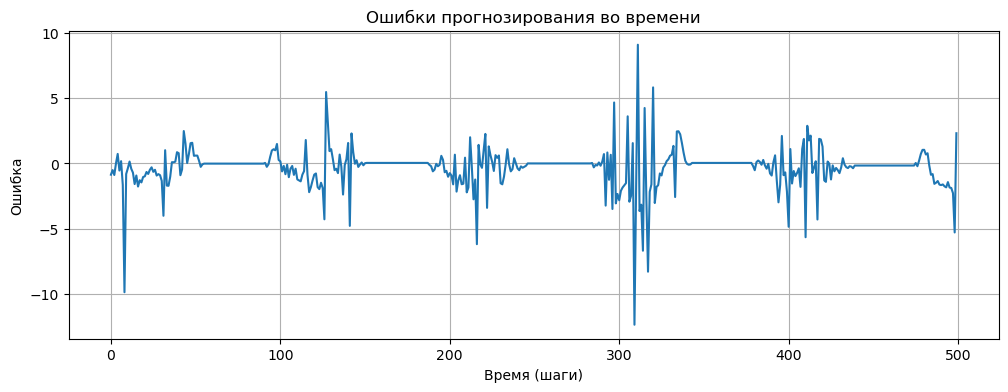

Number of month: 6


C:\Users\evb36\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


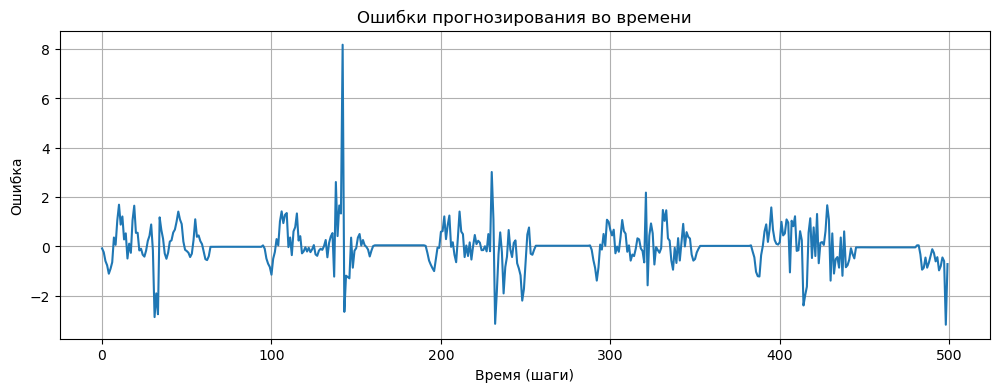

In [2702]:
# Обучение с кросс-валидацией
def spliter(X, n_splits=5):
    step = int(X.shape[0]/n_splits)
    for i in range(n_splits):
        test_start = i * step
        test_end = (i+1) * step
        train_indices = list(range(0, test_start)) + list(range(test_end, len(X)))
        test_indices = range(test_start, test_end)
        yield(
            train_indices,
            test_indices
        )
        
# Закоментирован вариант с последовательным разделением временных рядов

# from sklearn.model_selection import TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=4)
X, y, scaler_X, scaler_y = create_rolling_window_and_scale(data, look_back=4)

# for train_index, val_index in tscv.split(X):
#     X_train = X[train_index]
#     X_val = X[val_index]
#     y_train = y[train_index]
#     y_val = y[val_index]

# iterration = 1
month = 5
cross_val_error = {'MAE_full': [], 'MAPE_full': [], 'MAE_not_null': [], "MAPE_not_null": []}
for train_index, val_index in spliter(X, n_splits=7):
    # print(f'Number of iterration: {iterration}')
    # iterration += 1
    print(f'Number of month: {month}')
    month += 1
    X_train = X[train_index]
    X_val = X[val_index]
    y_train = y[train_index]
    y_val = y[val_index]
    model = Sequential([
        # Первый LSTM слой
        LSTM(120, activation='relu', recurrent_activation='sigmoid', 
             return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        
        # Второй LSTM слой
        LSTM(40, activation='relu', recurrent_activation='sigmoid'),
        Dropout(0.2),
        
        # Полносвязные слои
        Dense(15, activation='relu'),
        Dense(1)  # Выходной слой (регрессия)
    ])
    learning_rate = 0.005818401449418435
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mae', metrics=[custom_metrics.mape_to_max_power])
    early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[early_stop],
        verbose=0
    )
    y_pred = model.predict(X_val).reshape(-1, 1)
    # Обратное масштабирование данных для сравнения с реальными значениями
    y_val_original = scaler_y.inverse_transform(y_val)
    y_pred_original = scaler_y.inverse_transform(y_pred)
    # Check the metrics on the full test data
    cross_val_error['MAE_full'].append(metrics.mean_absolute_error(y_val_original, y_pred_original))
    cross_val_error['MAPE_full'].append(custom_metrics.mape_to_max_power(y_val_original, y_pred_original))

    # Find not null values
    y_val_df = pd.DataFrame(y_val)
    X_non_null = X_val[y_val_df > 0]
    y_non_null = y_val_df[y_val_df > 0].dropna()
    # Предсказание и обратное масштабирование
    y_pred_LSTM_non_null = model.predict(X_non_null.reshape(X_non_null.shape[0], 1, X_non_null.shape[1])).reshape(-1, 1)
    y_val_original_non_null = scaler_y.inverse_transform(y_non_null)
    y_pred_original_non_null = scaler_y.inverse_transform(y_pred_LSTM_non_null)

    cross_val_error['MAE_not_null'].append(metrics.mean_absolute_error(y_val_original_non_null, y_pred_original_non_null))
    cross_val_error['MAPE_not_null'].append(custom_metrics.mape_to_max_power(y_val_original_non_null, y_pred_original_non_null))
    
    errors = y_pred_original - y_val_original
    # build_errors_histplot(errors, stat_type="probability")
    # График ошибок во времени
    plt.figure(figsize=(12, 4))
    plt.plot(errors[0:500])
    plt.title('Ошибки прогнозирования во времени')
    plt.xlabel('Время (шаги)')
    plt.ylabel('Ошибка')
    plt.grid(True)
    plt.show()
    if month == 7: break

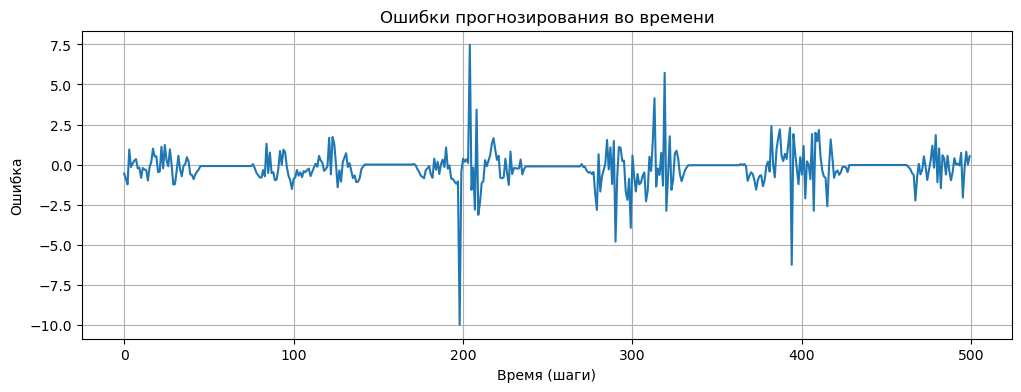

In [2706]:
plt.figure(figsize=(12, 4))
plt.plot(errors[500:1000])
plt.title('Ошибки прогнозирования во времени')
plt.xlabel('Время (шаги)')
plt.ylabel('Ошибка')
plt.grid(True)
plt.show()

In [2708]:
# np.mean(list_cross_val_mae)
np.mean(cross_val_error['MAPE_not_null'])
cross_val_error#['MAPE_not_null']

{'MAE_full': [0.6502156533604484, 0.6839281750213833],
 'MAPE_full': [<tf.Tensor: shape=(), dtype=float64, numpy=2.1615680129590156>,
  <tf.Tensor: shape=(), dtype=float64, numpy=2.279038414961559>],
 'MAE_not_null': [0.6806689969641992, 0.7243304432668806],
 'MAPE_not_null': [<tf.Tensor: shape=(), dtype=float64, numpy=2.2628066913594984>,
  <tf.Tensor: shape=(), dtype=float64, numpy=2.413669981178569>]}

## Check the metrics

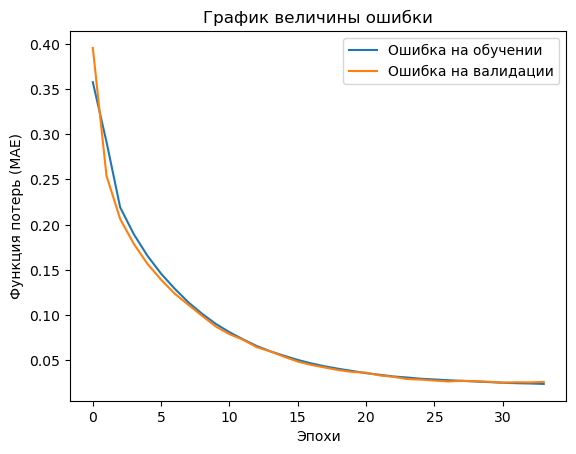

In [1818]:
# Визуализация процесса обучения
plt.plot(history.history['loss'], label='Ошибка на обучении')
plt.plot(history.history['val_loss'], label='Ошибка на валидации')
plt.title('График величины ошибки')
plt.xlabel('Эпохи')
plt.ylabel('Функция потерь (MAE)')
plt.legend()
plt.show()

In [1820]:
# Прогнозирование на валидационных данных
y_pred = model.predict(X_val).reshape(-1, 1)
# Обратное масштабирование данных для сравнения с реальными значениями
y_val_original = scaler_y.inverse_transform(y_val)
y_pred_original = scaler_y.inverse_transform(y_pred)
# Check the metrics on the full test data
mae = metrics.mean_absolute_error(y_val_original, y_pred_original)
rmse = metrics.root_mean_squared_error(y_val_original, y_pred_original)
mape = custom_metrics.mape_to_max_power(y_val_original, y_pred_original)
print(f"""MAE is {mae} 
RMSE is {rmse}
MAPE is {np.round(mape,4)}%
MAPE_nominal {np.round(mae/30*100,4)}%""")

477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step    
MAE is 0.5920817201766297 
RMSE is 1.5315512616828586
MAPE is 1.9683%
MAPE_nominal 1.9736%


In [1822]:
# Метрики на не нулевой валлидационной выборке
# исключаю нулевые значения
y_val_df = pd.DataFrame(y_val)
X_non_null = X_val[y_val_df > 0]
y_non_null = y_val_df[y_val_df > 0].dropna()
# Предсказание и обратное масштабирование
y_pred_LSTM_non_null = model.predict(X_non_null.reshape(X_non_null.shape[0], 1, X_non_null.shape[1])).reshape(-1, 1)
y_val_original_non_null = scaler_y.inverse_transform(y_non_null)
y_pred_original_non_null = scaler_y.inverse_transform(y_pred_LSTM_non_null)
# Control the metrics
mae = metrics.mean_absolute_error(y_val_original_non_null, y_pred_original_non_null)
rmse = metrics.mean_squared_error(y_val_original_non_null, y_pred_original_non_null)
mape = custom_metrics.mape_to_max_power(y_val_original_non_null, y_pred_original_non_null)

print(f"""MAE is {mae} 
RMSE is {rmse}
MAPE is {np.round(mape,4)}%
MAPE_nominal {np.round(mae/30*100,4)}%""")

296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
MAE is 0.9287854233831047 
RMSE is 3.7285008889964577
MAPE is 3.0876%
MAPE_nominal 3.096%


In [1824]:
# Прогнозирование на тестовых данных
y_pred_test = model.predict(X_test).reshape(-1, 1)
# Обратное масштабирование данных для сравнения с реальными значениями
y_test_original = scaler_y.inverse_transform(y_test)
y_pred_test_original = scaler_y.inverse_transform(y_pred_test)
# Check the metrics on the full test data
mae = metrics.mean_absolute_error(y_test_original, y_pred_test_original)
rmse = metrics.mean_squared_error(y_test_original, y_pred_test_original)
mape = custom_metrics.mape_to_max_power(y_test_original, y_pred_test_original)
print(f"""MAE is {mae} 
RMSE is {rmse}
MAPE is {np.round(mape, 4)}%
MAPE_nominal {np.round(mae/30*100, 4)}%""")

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
MAE is 0.3743756710095035 
RMSE is 1.017412045185497
MAPE is 1.2808%
MAPE_nominal 1.2479%


In [1826]:
# Метрики на не нулевой тестовой выборке
# исключаю нулевые значения
y_test_df = pd.DataFrame(y_test)
X_non_null = X_test[y_test_df > 0]
y_non_null = y_test_df[y_test_df > 0].dropna()
# Предсказание и обратное масштабирование
y_pred_test_non_null = model.predict(X_non_null.reshape(X_non_null.shape[0], 1, X_non_null.shape[1])).reshape(-1, 1)
y_test_original_non_null = scaler_y.inverse_transform(y_non_null)
y_pred_test_original_non_null = scaler_y.inverse_transform(y_pred_test_non_null)
# Control the metrics
mae = metrics.mean_absolute_error(y_test_original_non_null, y_pred_test_original_non_null)
rmse = metrics.mean_squared_error(y_test_original_non_null, y_pred_test_original_non_null)
mape = custom_metrics.mape_to_max_power(y_test_original_non_null, y_pred_test_original_non_null)
print(f"""MAE is {mae} 
RMSE is {rmse}
MAPE is {np.round(mape, 4)}%
MAPE_nominal {np.round(mae/30*100, 4)}%""")

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
MAE is 0.9184110103185407 
RMSE is 2.6566102357238037
MAPE is 3.1422%
MAPE_nominal 3.0614%


## Errors analysis

In [699]:
# # data_with_date = data.merge(date_data)
# _, train_data = data_split(data_with_date, train_size)
# train_data[min_interval:max_interval]

In [48]:
errors = y_val_original_non_null - y_pred_original_non_null
# error = y_test_original_non_null - y_pred_test_original_non_null

In [2007]:
from scipy import stats
stats.kstest(errors, 'cauchy', args=(x0_hat, 0.604))

KstestResult(statistic=array([0.17205622]), pvalue=array([2.91630304e-57]), statistic_location=array([0.02778816]), statistic_sign=array([1.]))

In [2724]:
len(errors)
# np.sum(error[error > 1.5])
np.sum(abs(errors) > 1.74)
np.std(errors)

1.5966368090776055

In [1977]:
stats.cauchy.fit(error)

(0.0005188091468589571, 0.30483102909240095)

In [39]:
def build_errors_histplot(error, stat_type='probability'):
    bin_list = [-20, -4, -3, -2.5, -2, -1.75, -1.5, -1.25, -1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4, 20]
    # bin_list_density = np.arange(-20, 20, 0.25)
    if stat_type != "probability" or stat_type =='both':
        plt.figure(figsize=(14,4))
        sns.histplot(error, bins=bin_list, kde=True)  # Распределение ошибок прогнозирования
        # sns.histplot(error, kde=True)
        # plt.grid(axis = 'x')
        plt.xticks(np.arange(-10, 10, 0.5))
        plt.xlabel('Отклонение мощности, МВт')
        plt.title("Распределение ошибок прогнозирования")
        plt.ylabel('Количество ошибок')
        plt.xlim(-5, 5)
        plt.show()
    if stat_type == "probability" or stat_type =='both':
        # Density of probability
        plt.figure(figsize=(16,6))
        sns.histplot(error, bins=bin_list, kde=True, stat='probability', label='Кривая распределения ошибок')
        # plt.plot(x, stats.norm.pdf(x, loc=-0.139, scale=1.74), 'r-', label="Нормальное (x0=-0.14, σ=1.74)")
        # plt.plot(x, stats.cauchy.pdf(x, loc=0.0005, scale=0.6), 'g--', label="Коши (x0=0, γ=0.6)")
        plt.title("Срвнение распределения плотности вероятности")
        plt.legend()
        plt.xlabel('Отклонение мощности, МВт')
        plt.ylabel('Вероятность')
        plt.xticks(np.arange(-10, 10, 0.5))
        # plt.yticks(np.arange(0, 1.1, 0.1))
        plt.xlim(-5, 5)
        plt.show()

In [2479]:
# from scipy.stats import laplace

# # Оценка параметров
# loc, scale = laplace.fit(error)

# # Визуализация
# x = np.linspace(min(error), max(error), 1000)
# plt.hist(error, bins=50, density=True, alpha=0.5, label='Данные')
# plt.plot(x, laplace.pdf(x, loc, scale), 'r-', label='Лаплас')
# plt.legend()
# plt.xlim(-5, 5)
# plt.show()

In [2477]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# # График ошибок во времени
# plt.figure(figsize=(12, 4))
# plt.plot(error)
# plt.title('Ошибки прогнозирования во времени')
# plt.xlabel('Время (шаги)')
# plt.ylabel('Ошибка')
# plt.grid(True)
# plt.show()

# # ACF и PACF
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
# plot_acf(error, lags=4, ax=ax1, title='Автокорреляция (ACF)')
# plot_pacf(error, lags=4, ax=ax2, title='Частная автокорреляция (PACF)')
# plt.tight_layout()
# plt.show()

## Visualisation

Средняя абсолютная ошибка (MAE) на интервале валидационных данных: 0.21492632725211339
Корень из средней квадратичной ошибки (RMSE) на интервале валидационных данных: 0.1085857079124546
Средняя абсолютная ошибка приведённая к максимальной генерацие (MAPE) на интервале валидационных данных: 3.08%
Средняя абсолютная ошибка приведённая к номинальной генерацие (MAPE_nominal) на интервале валидационных данных: 0.7164%


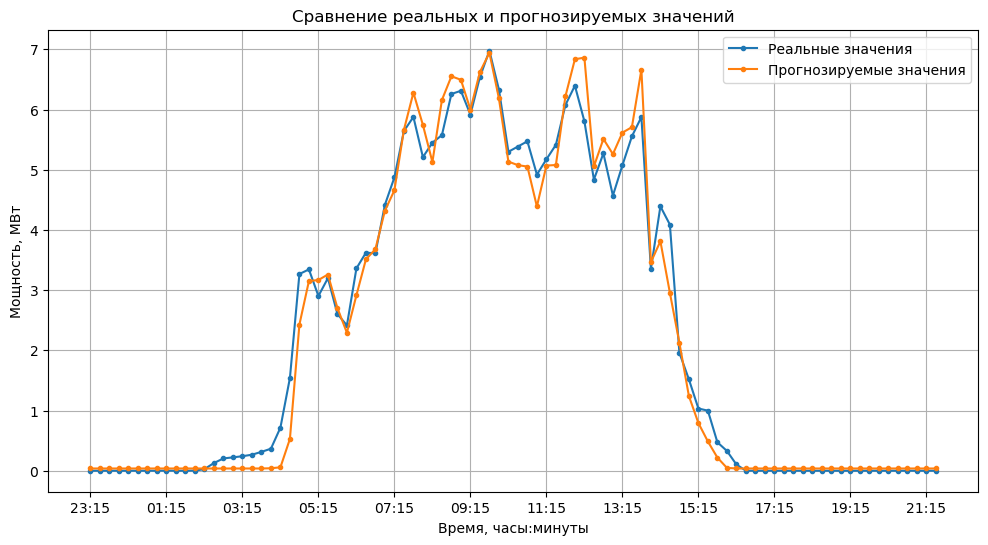

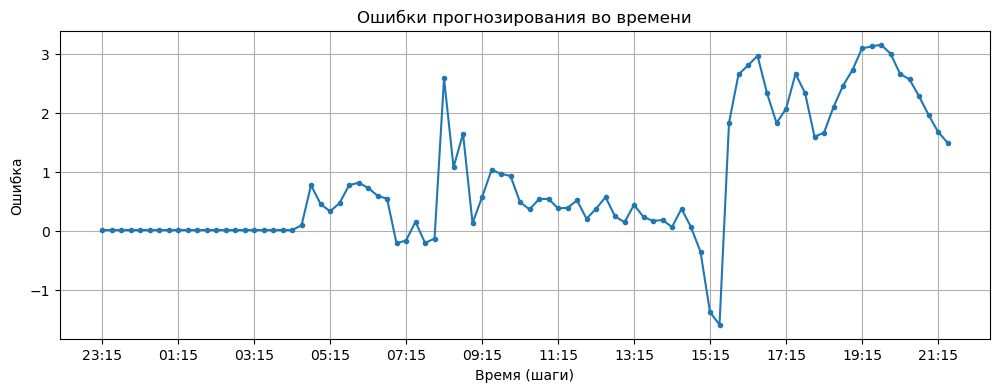

(15249, 1)

In [1828]:
# Выбор интервала на валидационных данных
min_interval = 850 # #73 1518
max_interval = 940 # #121 1560
# Считаю ошибку на интервале
mae = metrics.mean_absolute_error(y_val_original[min_interval:max_interval], y_pred_original[min_interval:max_interval])
rmse = metrics.mean_squared_error(y_val_original[min_interval:max_interval], y_pred_original[min_interval:max_interval])
mape = custom_metrics.mape_to_max_power(y_val_original[min_interval:max_interval], y_pred_original[min_interval:max_interval])
print(f"""Средняя абсолютная ошибка (MAE) на интервале валидационных данных: {mae}
Корень из средней квадратичной ошибки (RMSE) на интервале валидационных данных: {rmse}
Средняя абсолютная ошибка приведённая к максимальной генерацие (MAPE) на интервале валидационных данных: {np.round(mape, 2)}%
Средняя абсолютная ошибка приведённая к номинальной генерацие (MAPE_nominal) на интервале валидационных данных: {np.round(mae/30*100,4)}%""")
# Получаю время для добавления меток времени к графику
train_size_ = 0.8
train_size = int(len(data) * train_size_)
_, date_data_test = data_split(date_data, train_size)
x_time = date_data_test[min_interval:max_interval].apply(lambda x: (x + dt.timedelta(hours=0)).strftime('%H:%M'))
# Визуалитзация интервала
plt.figure(figsize=(12,6))
plt.plot(x_time, y_val_original[min_interval:max_interval], label='Реальные значения', marker='.')
plt.plot(x_time, y_pred_original[min_interval:max_interval], label='Прогнозируемые значения', marker='.')
plt.xticks(range(0, (max_interval-min_interval), 8)) # регулирую колличество меток по оси х
plt.title('Сравнение реальных и прогнозируемых значений')
plt.xlabel('Время, часы:минуты')
plt.ylabel('Мощность, МВт')
plt.grid(True)
plt.legend()
plt.show()
# График ошибки
plt.figure(figsize=(12, 4))
plt.plot(x_time, errors[min_interval:max_interval], marker='.')
plt.title('Ошибки прогнозирования во времени')
plt.xlabel('Время (шаги)')
plt.ylabel('Ошибка')
plt.xticks(range(0, (max_interval-min_interval), 8)) # регулирую колличество меток по оси х
plt.grid(True)
plt.show()
y_val_original.shape

In [1896]:
data_test.merge(data_)

,Fact_Pgen,Insolation,Temperature,Wind_speed,relative_humidity_2m (%),precipitation (mm)
15254,0.0,0,1.6,0.7,68.0,0.0
15255,0.0,0,2.1,1.4,67.0,0.0
15256,0.0,0,0.2,2.3,67.0,0.0
15257,0.0,0,-0.1,2,68.0,0.0
15258,0.0,0,-1.1,1.9,69.0,0.0
...,...,...,...,...,...,...
21787,0.0,0,-11.4,5.1,71.0,0.0
21788,0.0,0,-11.9,5,71.0,0.0
21789,0.0,0,-11.6,4.1,71.0,0.0
21790,0.0,0,-12.6,4.6,72.0,0.0


Средняя абсолютная ошибка (MAE) на интервале тестовых данных: 0.14528959470076744
Корень из средней квадратичной ошибки (RMSE) на интервале тестовых данных: 0.1085857079124546
Средняя абсолютная ошибка приведённая к максимальной генерацие (MAPE) на интервале тестовых данных: 2.09%
Средняя абсолютная ошибка приведённая к номинальной генерацие (MAPE_nominal) на интервале тестовых данных: 0.4843%


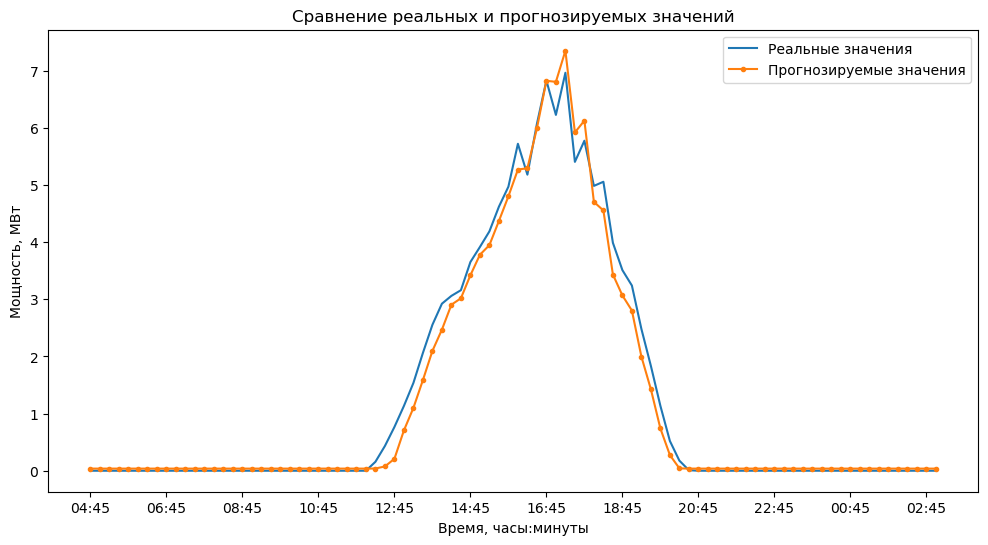

In [1894]:
# Выбор интервала на тестовых данных
min_interval = 4500 # 622 105 526
max_interval = 4590 # 658 182 561
# Считаю ошибку на интервале
mae = metrics.mean_absolute_error(y_test_original[min_interval:max_interval], y_pred_test_original[min_interval:max_interval])
mse = metrics.mean_squared_error(y_test_original[min_interval:max_interval], y_pred_test_original[min_interval:max_interval])
mape = custom_metrics.mape_to_max_power(y_test_original[min_interval:max_interval], y_pred_test_original[min_interval:max_interval])
print(f"""Средняя абсолютная ошибка (MAE) на интервале тестовых данных: {mae}
Корень из средней квадратичной ошибки (RMSE) на интервале тестовых данных: {rmse}
Средняя абсолютная ошибка приведённая к максимальной генерацие (MAPE) на интервале тестовых данных: {np.round(mape, 2)}%
Средняя абсолютная ошибка приведённая к номинальной генерацие (MAPE_nominal) на интервале тестовых данных: {np.round(mae/30*100,4)}%""")
# Получаю время для добавления меток времени к графику
x_time = date_data_test[min_interval:max_interval].apply(lambda x: (x + dt.timedelta(hours=5)).strftime('%H:%M'))
# Визуалитзация интервала
plt.figure(figsize=(12,6))
plt.plot(x_time, y_test_original[min_interval:max_interval], label='Реальные значения')
plt.plot(x_time, y_pred_test_original[min_interval:max_interval], label='Прогнозируемые значения', marker='.')
plt.xticks(range(0, (max_interval-min_interval), 8)) # регулирую колличество меток по оси х
plt.title('Сравнение реальных и прогнозируемых значений')
plt.xlabel('Время, часы:минуты')
plt.ylabel('Мощность, МВт')
plt.legend()
plt.show()

## Khorinskaya

In [229]:
y_pred_new = scaler_y.inverse_transform(model.predict(X_train))
y_train_original = scaler_y.inverse_transform(y_train)
metrics.mean_absolute_error(y_train_original, y_pred_new)/15*100

1001/1001 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step


1.5088134071446444

In [231]:
y_pred_val_original = scaler_y.inverse_transform(model.predict(X_val))
y_val_original = scaler_y.inverse_transform(y_val)
metrics.mean_absolute_error(y_val_original, y_pred_val_original)/15*100

251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


1.3417510330964684

Средняя абсолютная ошибка (MAE) на интервале тестовых данных: 0.1495392146623796
Корень из средней квадратичной ошибки (RMSE) на интервале тестовых данных: 1.225555126347361
Средняя абсолютная ошибка приведённая к максимальной генерацие (MAPE) на интервале тестовых данных: 1.9%
Средняя абсолютная ошибка приведённая к номинальной генерацие (MAPE_nominal) на интервале тестовых данных: 0.9969%


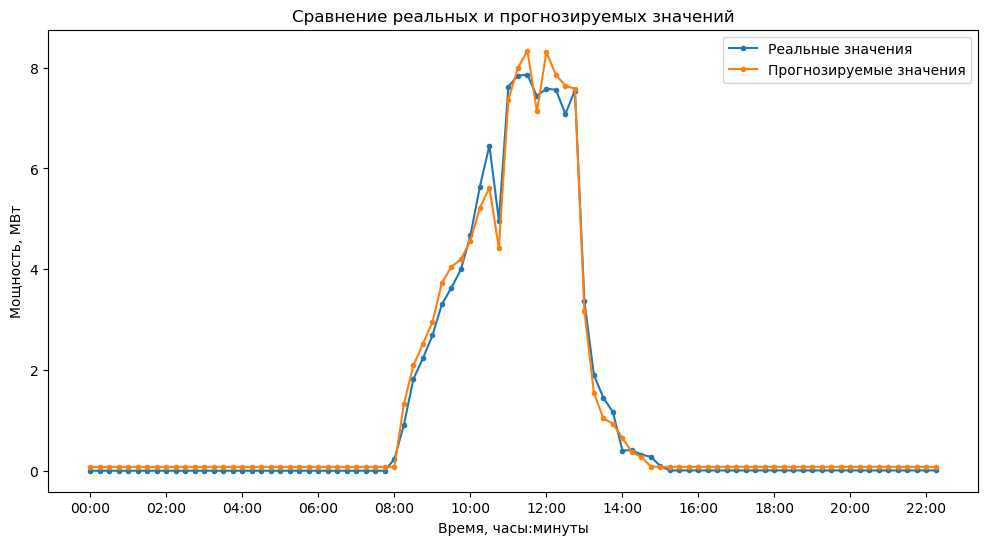

In [235]:
# Выбор интервала на тестовых данных
min_interval = 30220 # 622 105 526
max_interval = 30310 # 658 182 561
# Считаю ошибку на интервале
mae = metrics.mean_absolute_error(y_train_original[min_interval:max_interval], y_pred_new[min_interval:max_interval])
mse = metrics.mean_squared_error(y_train_original[min_interval:max_interval], y_pred_new[min_interval:max_interval])
mape = custom_metrics.mape_to_max_power(y_train_original[min_interval:max_interval], y_pred_new[min_interval:max_interval])
print(f"""Средняя абсолютная ошибка (MAE) на интервале тестовых данных: {mae}
Корень из средней квадратичной ошибки (RMSE) на интервале тестовых данных: {rmse}
Средняя абсолютная ошибка приведённая к максимальной генерацие (MAPE) на интервале тестовых данных: {np.round(mape, 2)}%
Средняя абсолютная ошибка приведённая к номинальной генерацие (MAPE_nominal) на интервале тестовых данных: {np.round(mae/15*100,4)}%""")
# Получаю время для добавления меток времени к графику
x_time = data_khorinskaya_with_date.Date[min_interval:max_interval].apply(lambda x: (x + dt.timedelta(hours=5)).strftime('%H:%M'))
# Визуалитзация интервала
plt.figure(figsize=(12,6))
plt.plot(x_time, y_train_original[min_interval:max_interval], label='Реальные значения', marker='.')
plt.plot(x_time, y_pred_new[min_interval:max_interval], label='Прогнозируемые значения', marker='.')
plt.xticks(range(0, (max_interval-min_interval), 8)) # регулирую колличество меток по оси х
plt.title('Сравнение реальных и прогнозируемых значений')
plt.xlabel('Время, часы:минуты')
plt.ylabel('Мощность, МВт')
plt.legend()
plt.show()

Средняя абсолютная ошибка (MAE) на интервале тестовых данных: 0.29744823575685014
Корень из средней квадратичной ошибки (RMSE) на интервале тестовых данных: 1.225555126347361
Средняя абсолютная ошибка приведённая к максимальной генерацие (MAPE) на интервале тестовых данных: 2.54%
Средняя абсолютная ошибка приведённая к номинальной генерацие (MAPE_nominal) на интервале тестовых данных: 1.983%


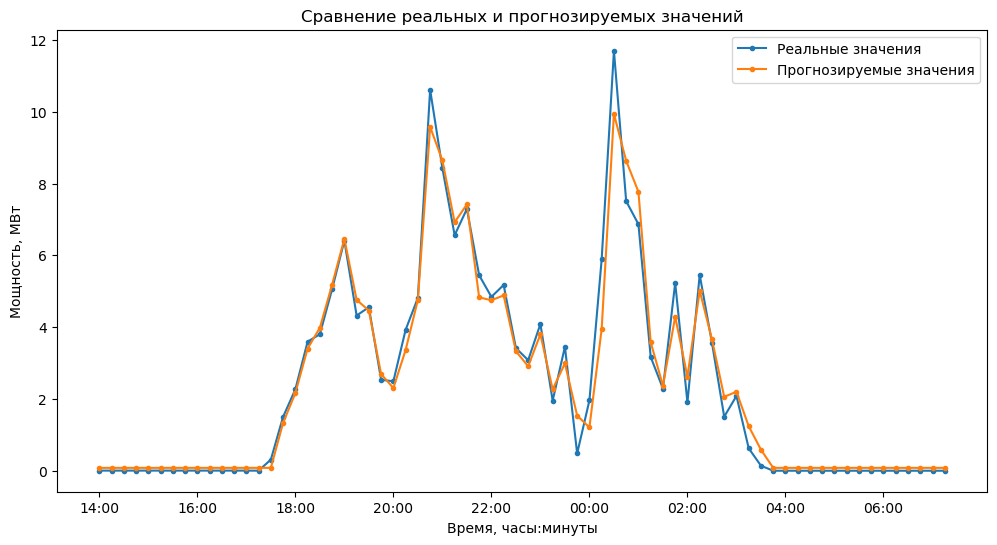

In [237]:
# Выбор интервала на валидационных данных
min_interval = 2820  # 
max_interval = 2890  # 
# Считаю ошибку на интервале
mae = metrics.mean_absolute_error(y_val_original[min_interval:max_interval], y_pred_val_original[min_interval:max_interval])
mse = metrics.mean_squared_error(y_val_original[min_interval:max_interval], y_pred_val_original[min_interval:max_interval])
mape = custom_metrics.mape_to_max_power(y_val_original[min_interval:max_interval], y_pred_val_original[min_interval:max_interval])
print(f"""Средняя абсолютная ошибка (MAE) на интервале тестовых данных: {mae}
Корень из средней квадратичной ошибки (RMSE) на интервале тестовых данных: {rmse}
Средняя абсолютная ошибка приведённая к максимальной генерацие (MAPE) на интервале тестовых данных: {np.round(mape, 2)}%
Средняя абсолютная ошибка приведённая к номинальной генерацие (MAPE_nominal) на интервале тестовых данных: {np.round(mae/15*100,4)}%""")
# Получаю время для добавления меток времени к графику
x_time = data_khorinskaya_with_date.Date[min_interval:max_interval].apply(lambda x: (x + dt.timedelta(hours=5)).strftime('%H:%M'))
# Визуалитзация интервала
plt.figure(figsize=(12,6))
plt.plot(x_time, y_val_original[min_interval:max_interval], label='Реальные значения', marker='.')
plt.plot(x_time, y_pred_val_original[min_interval:max_interval], label='Прогнозируемые значения', marker='.')
plt.xticks(range(0, (max_interval-min_interval), 8)) # регулирую колличество меток по оси х
plt.title('Сравнение реальных и прогнозируемых значений')
plt.xlabel('Время, часы:минуты')
plt.ylabel('Мощность, МВт')
plt.legend()
plt.show()

In [77]:
data_khorinskaya_with_date.iloc[30100]

Date                        2025-01-08 13:00:00
Pgen                                          0
Insolation                                    0
Temperature                               -24.5
Wind_Speed                                  1.6
relative_humidity_2m (%)                     78
precipitation (mm)                          0.0
Name: 30100, dtype: object

In [2673]:
# data[18651:19000].head(60)